In [78]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [79]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [80]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# experiment = "Tonsil"
# cores=['DonorA', 'DonorE']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]

experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']

experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

# Load data

In [82]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [83]:
df_sums = []
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    # df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
    #     df_morph["area"], axis=0
    # )
    # pseudo_count=1
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    # data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    df_intensity_IMC.set_index("Id", inplace=True)
    adata_IMC = sc.AnnData(df_intensity_IMC.values)
    adata_IMC.var_names = df_intensity_IMC.columns.tolist()
    sc.pp.scale(adata_IMC)

    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    # sc.pp.normalize_total(adata, target_sum=1e5)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    
    adata = ad.concat([adata, adata_IMC], axis=1)
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    adatas.append(adata)
    
    
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset L11_2
Sucessfully read dataset L11_3


C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_IMC = sc.AnnData(df_intensity_IMC.values)
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:34: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)

Sucessfully read dataset L128_1
Sucessfully read dataset L128_2


C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_IMC = sc.AnnData(df_intensity_IMC.values)
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:34: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)

Sucessfully read dataset L128_3


C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_IMC = sc.AnnData(df_intensity_IMC.values)
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\1760883581.py:34: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [84]:
IMC_markers = df_intensity_IMC.columns
SIMS_masses = df_intensity_TS.columns[1:]

In [85]:
IMC_markers

Index(['CD3', 'CD45RA', 'CD45RO', 'CD8a', 'DNA1', 'DNA2', 'Ecaderin',
       'PanKeratin', 'SMA', 'Vimentin'],
      dtype='object')

In [86]:
# IMC_markers = IMC_markers.drop(["CD138", "FoxP3", "BCL6", "CD86", "CD83", "CXCR4", "DNA1", "DNA2", "CD11b", "CD11c",'H3K27me3'])

In [87]:
# IMC_markers = IMC_markers.drop(["CD11b", "CD11c", "DNA1", "DNA2", "HistoneH3",'MHCII'])

In [88]:
IMC_markers = IMC_markers.drop(["DNA1", "DNA2"])

In [89]:
print(len(SIMS_masses), len(IMC_markers))

191 8


In [90]:
adata

AnnData object with n_obs × n_vars = 8215 × 202
    obs: 'Cell', 'Dataset', 'Core'
    obsm: 'spatial'

# SIMS data

In [91]:
h5_data_dir = p_dir / "data" / "h5"

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    plt.imshow(mz_img, cmap='hot')  
    plt.title(f'{mz} m/z')
    plt.show()

In [92]:
masses = [
    50,
    190,
    191,
    193,
    194,
    196,
    198,
    200,
    201,
    202,
    203,
    55,
    204,
    205,
    206,
    207,
    208,
    209,
    210,
    212,
    214,
    216,
    56,
    217,
    220,
    221,
    222,
    223,
    224,
    225,
    226,
    229,
    232,
    57,
    236,
    238,
    240,
    243,
    246,
    248,
    249,
    250,
    252,
    253,
    58,
    254,
    256,
    259,
    261,
    263,
    265,
    267,
    269,
    273,
    275,
    59,
    276,
    279,
    282,
    289,
    301,
    307,
    308,
    310,
    318,
    60,
    328,
    332,
    339,
    344,
    353,
    359,
    369,
    380,
    385,
    397,
    61,
    412,
    424,
    431,
    436,
    448,
    457,
    468,
    474,
    479,
    498,
    63,
    501,
    510,
    514,
    518,
    520,
    529,
    544,
    552,
    570,
    586,
    64,
    593,
    610,
    1,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    16,
    76,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    17,
    87,
    88,
    91,
    93,
    95,
    96,
    97,
    98,
    100,
    102,
    30,
    104,
    105,
    107,
    109,
    111,
    112,
    115,
    116,
    117,
    118,
    34,
    121,
    122,
    124,
    125,
    127,
    128,
    131,
    133,
    134,
    138,
    35,
    140,
    141,
    143,
    144,
    145,
    146,
    148,
    149,
    150,
    151,
    42,
    153,
    155,
    156,
    158,
    159,
    161,
    162,
    164,
    165,
    166,
    44,
    167,
    168,
    169,
    170,
    171,
    173,
    179,
    182,
    184,
    185,
]
masses.sort()

In [93]:
# # --- Read tof-sims images
# imgs, labels = get_imgs_sims(experiment, dataset)
# IMS(imgs, 79.0, masses)

In [94]:
all_markers = IMC_markers.append(SIMS_masses)

# Get SIMS data
adata_SIMS = adata[:, all_markers]
sc.pp.scale(adata_SIMS)
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=adata_SIMS.var_names)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [95]:
# Define col type
type_pal = sns.color_palette("hls", 2)
type_lut = dict(zip(map(str, ['IMC', 'SIMS']), type_pal))
type_labels = np.concatenate([['IMC' for _ in range(len(IMC_markers))], ['SIMS' for _ in range(len(SIMS_masses))]])
type_colors = pd.Series(type_labels, index=all_markers).map(type_lut)


In [96]:
IMC_markers

Index(['CD3', 'CD45RA', 'CD45RO', 'CD8a', 'Ecaderin', 'PanKeratin', 'SMA',
       'Vimentin'],
      dtype='object')

In [97]:
# from matplotlib.colors import LogNorm
# from matplotlib.pyplot import gcf

# g = sns.clustermap(df_SIMS,
#                    col_colors=type_colors,
#                    cmap='coolwarm', 
#                    row_cluster=True,
#                    col_cluster=True,
#                    cbar_pos=(.0, .32, .02, .2), 
#                    dendrogram_ratio=(.05, .05), 
#                    figsize=(25, 10), 
#                    yticklabels=False, 
#                    xticklabels=True, 
#                    vmax=2.5,
#                    vmin=-2.5)
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
# g.ax_row_dendrogram.set_visible(False)


# handles1 = [Patch(facecolor=type_lut[name]) for name in type_lut]
# l1 = plt.legend(handles1, type_lut, title='Modality', bbox_to_anchor=(1, 0.95), bbox_transform=plt.gcf().transFigure, loc='upper left')
# plt.gca().add_artist(l1)

# plt.show()

# Get literature lut

In [98]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.5
matched_dfs = []
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
        
matched = pd.concat(matched_dfs)

C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\2240849879.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\2240849879.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_9620\2240849879.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [99]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 90


In [100]:
# Selected channel
all_markers = IMC_markers.append(SIMS_masses_subset)
all_markers_name = IMC_markers.append(SIMS_nm_subset)

# Get SIMS data
adata_SIMS = adata[:, all_markers]
sc.pp.scale(adata_SIMS)
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=all_markers_name)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [101]:
# Define column type
type_lut = dict(zip(map(str, ['IMC', 'SIMS']), "rb"))
type_labels = np.concatenate([['IMC' for _ in range(len(IMC_markers))], ['SIMS' for _ in range(len(SIMS_masses_subset))]])
type_colors = pd.Series(type_labels, index=all_markers_name).map(type_lut)

# Define column subtype
subtype_labels = np.concatenate([['Protein' for _ in range(len(IMC_markers))], SIMS_type_subset])
subtype_pal = sns.color_palette("Accent", len(np.unique(subtype_labels)))
subtype_lut = dict(zip(map(str, np.unique(subtype_labels)), subtype_pal))
subtype_colors = pd.Series(subtype_labels, index=all_markers_name).map(subtype_lut)

# Define row type
core_labels = adata_SIMS.obs['Dataset'].tolist()
core_pal = sns.color_palette("tab20", len(np.unique(core_labels)))
core_lut = dict(zip(map(str, np.unique(core_labels)), core_pal))
core_colors = adata_SIMS.obs['Dataset'].reset_index(drop=True).map(core_lut).rename('')

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


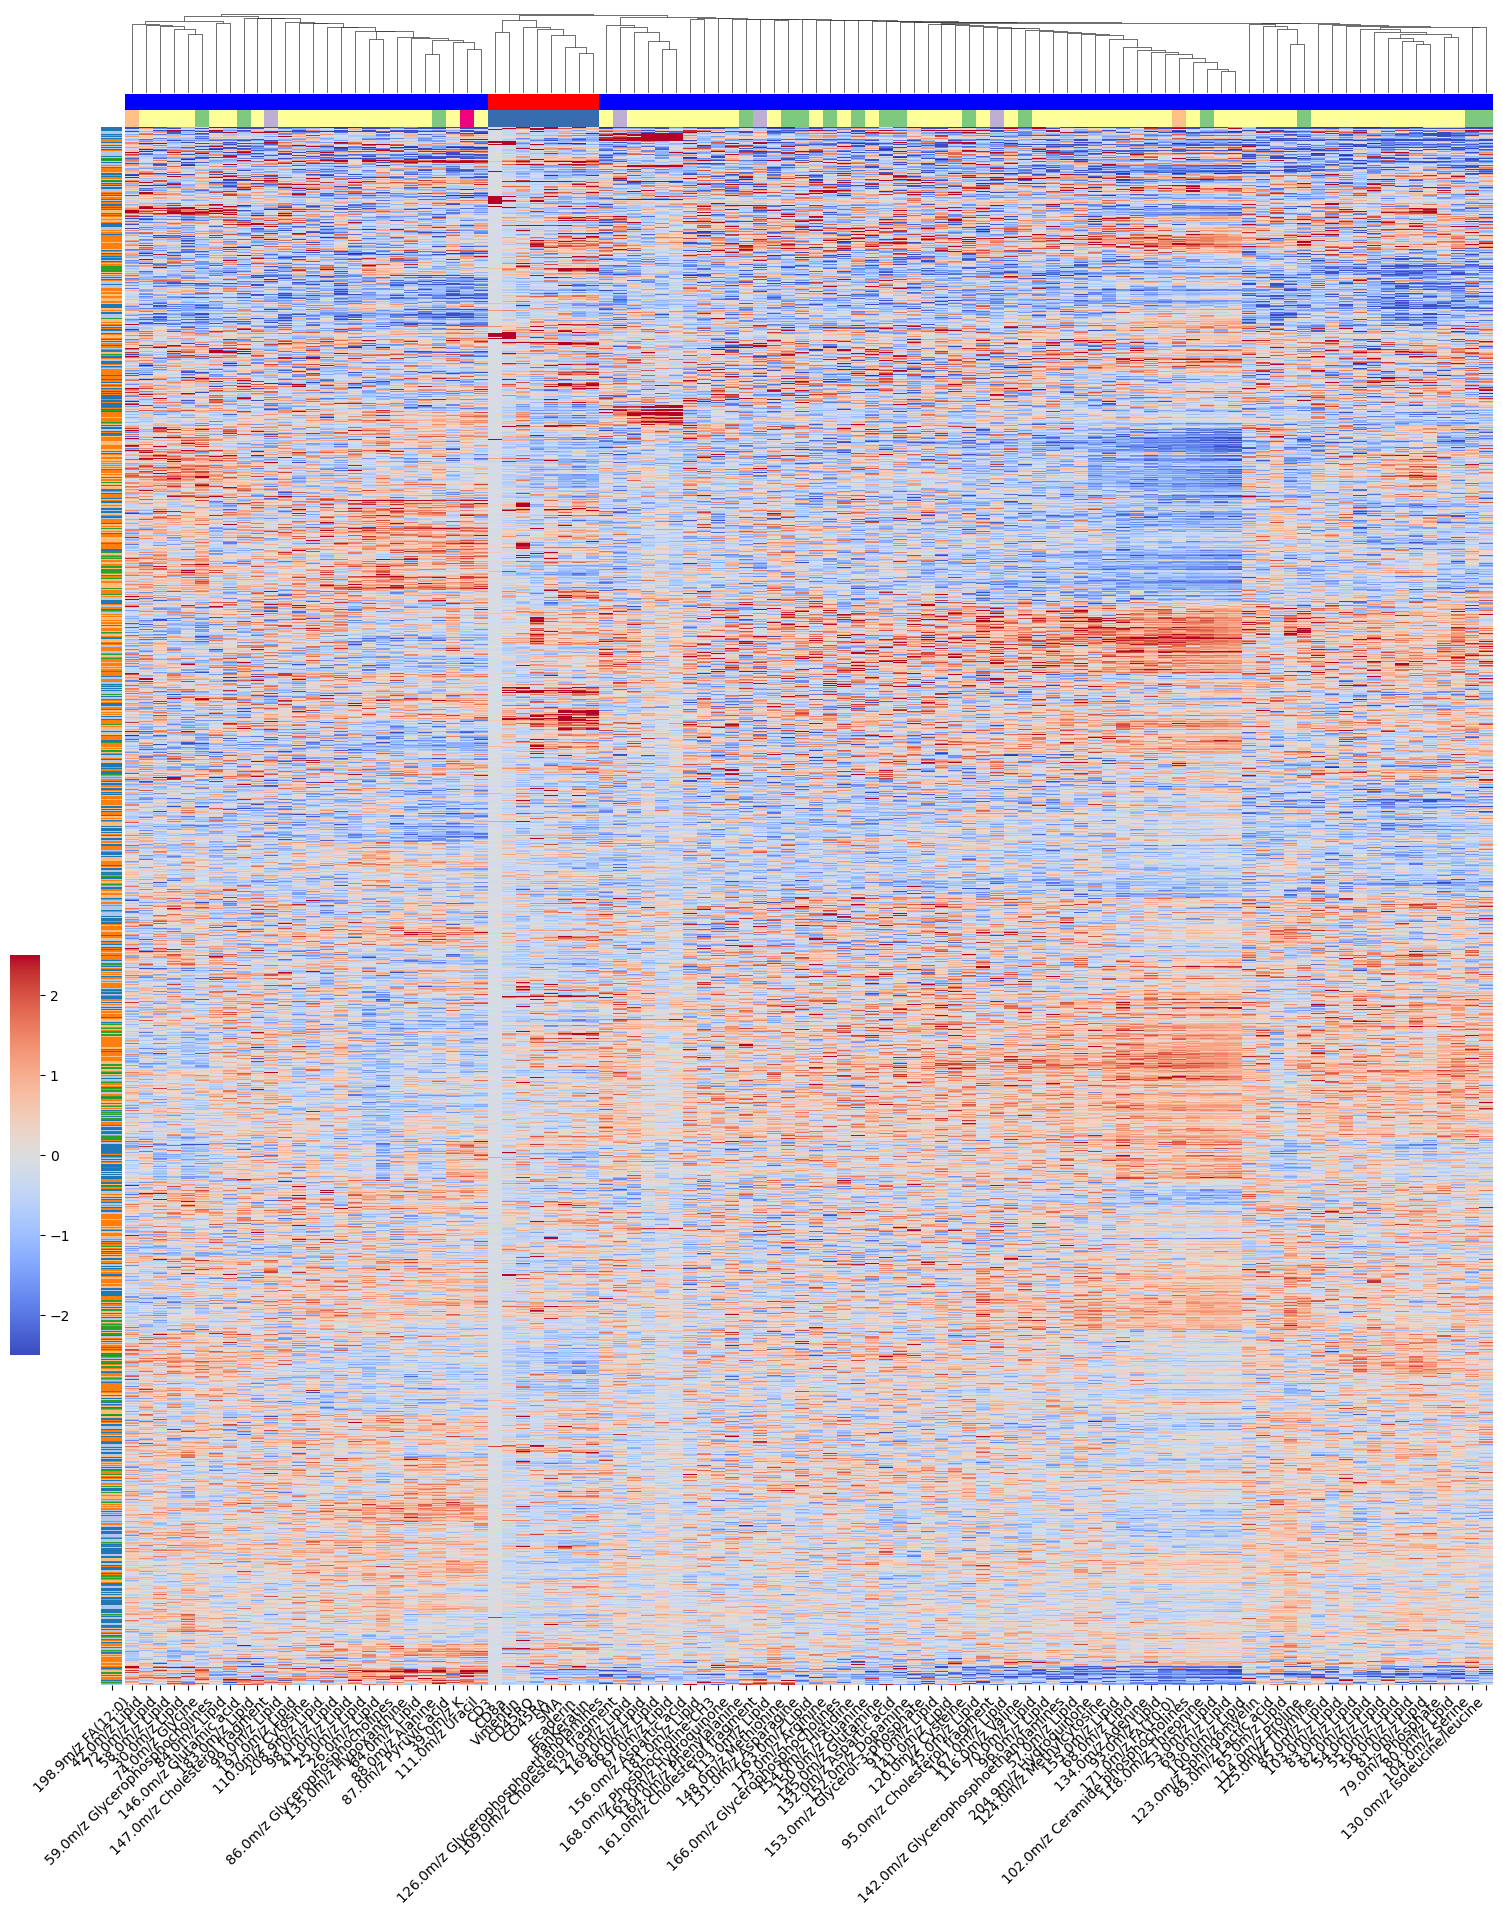

In [102]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS,
                   row_colors=core_colors,
                   col_colors=[type_colors, subtype_colors],
                   cmap='coolwarm', 
                   row_cluster=True,
                   col_cluster=True,
                   colors_ratio = (0.015, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(15, 20), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2.5,
                   vmin=-2.5)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

handles1 = [Patch(facecolor=type_lut[name]) for name in type_lut]
l1 = plt.legend(handles1, type_lut, title='Modality', bbox_to_anchor=(1, 0.95), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles2 = [Patch(facecolor=subtype_lut[name]) for name in subtype_lut]
l2 = plt.legend(handles2, subtype_lut, title='Subtype', bbox_to_anchor=(1, 0.85), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles3 = [Patch(facecolor=core_lut[name]) for name in core_lut]
l3 = plt.legend(handles3, core_lut, title='ROI', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.gca().add_artist(l1)
plt.gca().add_artist(l2)
plt.gca().add_artist(l3)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right') 
plt.show()

# Get protein clustering

In [153]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## all masses

In [154]:
all_markers = IMC_markers.append(SIMS_masses)

# Get SIMS data
adata_SIMS = adata[:, all_markers]
sc.pp.scale(adata_SIMS)
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=adata_SIMS.var_names)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [155]:
# Get cluster 
cluster = adata_IMC_cluster.obs['leiden'].to_list()

# Append cluster info to single-cell matrix info for sorting and then take out cluster info
df_SIMS.loc[:,'cluster'] = np.array(cluster).astype(np.uint8)
df_SIMS_sort = df_SIMS.sort_values('cluster')
df_SIMS_sort.drop('cluster', axis=1, inplace=True)

In [156]:
# Define col type
type_pal = sns.color_palette("hls", 2)
type_lut = dict(zip(map(str, ['IMC', 'SIMS']), type_pal))
type_labels = np.concatenate([['IMC' for _ in range(len(IMC_markers))], ['SIMS' for _ in range(len(SIMS_masses))]])
type_colors = pd.Series(type_labels, index=all_markers).map(type_lut)

# Define row type
core_labels = np.array(cluster).astype(np.uint8)
core_pal = sns.color_palette(adata_IMC_cluster.uns['leiden_colors'])
core_lut = dict(zip(map(str, np.unique(core_labels)), core_pal))
core_colors = adata_IMC_cluster.obs['leiden'].reset_index(drop=True).astype(str).map(core_lut).rename('')

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


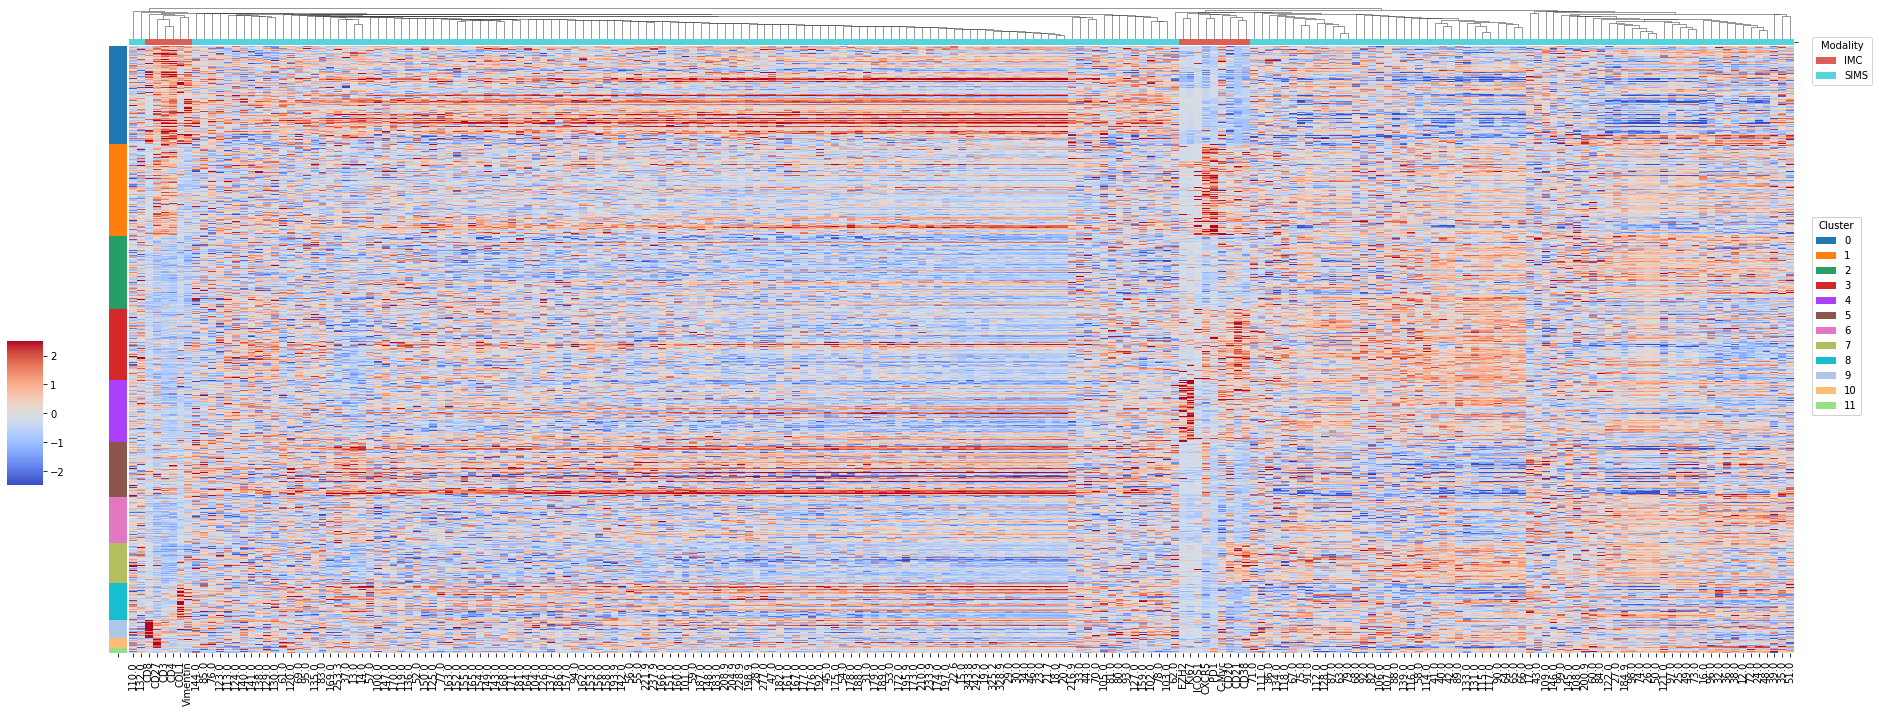

In [157]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS_sort,
                   row_colors=core_colors,
                   col_colors=type_colors,
                   cmap='coolwarm', 
                   row_cluster=False,
                   col_cluster=True,
                   colors_ratio = (0.01, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(25, 10), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2.5,
                   vmin=-2.5)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

handles1 = [Patch(facecolor=type_lut[name]) for name in type_lut]
l1 = plt.legend(handles1, type_lut, title='Modality', bbox_to_anchor=(1, 0.95), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles3 = [Patch(facecolor=core_lut[name]) for name in core_lut]
l2 = plt.legend(handles3, core_lut, title='Cluster', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.gca().add_artist(l1)
plt.gca().add_artist(l2)

plt.show()

## Literature matched masses

In [158]:
# Selected channel
all_markers = IMC_markers.append(SIMS_masses_subset)
all_markers_name = IMC_markers.append(SIMS_nm_subset)

# Get SIMS data
adata_SIMS = adata[:, all_markers]
sc.pp.scale(adata_SIMS)
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=all_markers_name)

KeyError: "Values ['42', '59', '79', '86', '87', '89', '95', '102', '104', '109', '110', '111', '114', '116', '124', '125', '126', '130', '131', '134', '135', '142', '145', '146', '147', '150', '152', '153', '154', '156', '161', '164', '165', '166', '168', '171', '173', '174', '179', '198', '204', '253', '277'], from ['C-Myc', 'CD20', 'CD21', 'CD27', 'CD3', 'CD38', 'CD4', 'CD8', 'COL1', 'CXCR5', 'EZH2', 'ICOS1', 'Ki67', 'PD1', 'Vimentin', '42', '59', '79', '86', '87', '89', '95', '102', '104', '109', '110', '111', '114', '116', '124', '125', '126', '130', '131', '134', '135', '142', '145', '146', '147', '150', '152', '153', '154', '156', '161', '164', '165', '166', '168', '171', '173', '174', '179', '198', '204', '253', '277'], are not valid obs/ var names or indices."

In [ ]:
# Get cluster 
cluster = adata_IMC_cluster.obs['leiden'].to_list()

# Append cluster info to single-cell matrix info for sorting and then take out cluster info
df_SIMS.loc[:,'cluster'] = np.array(cluster).astype(np.uint8)
df_SIMS_sort = df_SIMS.sort_values('cluster')
df_SIMS_sort.drop('cluster', axis=1, inplace=True)

In [ ]:
# Define column type
type_lut = dict(zip(map(str, ['IMC', 'SIMS']), "rb"))
type_labels = np.concatenate([['IMC' for _ in range(len(IMC_markers))], ['SIMS' for _ in range(len(SIMS_masses_subset))]])
type_colors = pd.Series(type_labels, index=all_markers_name).map(type_lut)

# Define column subtype
subtype_labels = np.concatenate([['Protein' for _ in range(len(IMC_markers))], SIMS_type_subset])
subtype_pal = sns.color_palette("Accent", len(np.unique(subtype_labels)))
subtype_lut = dict(zip(map(str, np.unique(subtype_labels)), subtype_pal))
subtype_colors = pd.Series(subtype_labels, index=all_markers_name).map(subtype_lut)

# Define row type
core_labels = np.array(cluster).astype(np.uint8)
core_pal = sns.color_palette(adata_IMC_cluster.uns['leiden_colors'])
core_lut = dict(zip(map(str, np.unique(core_labels)), core_pal))
core_colors = adata_IMC_cluster.obs['leiden'].reset_index(drop=True).astype(str).map(core_lut).rename('')

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS_sort,
                   row_colors=core_colors,
                   col_colors=[type_colors, subtype_colors],
                   cmap='coolwarm', 
                   row_cluster=False,
                   col_cluster=True,
                   colors_ratio = (0.015, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(12, 20), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2.5,
                   vmin=-2.5)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

handles1 = [Patch(facecolor=type_lut[name]) for name in type_lut]
l1 = plt.legend(handles1, type_lut, title='Modality', bbox_to_anchor=(1, 0.95), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles2 = [Patch(facecolor=subtype_lut[name]) for name in subtype_lut]
l2 = plt.legend(handles2, subtype_lut, title='Subtype', bbox_to_anchor=(1, 0.85), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles3 = [Patch(facecolor=core_lut[name]) for name in core_lut]
l3 = plt.legend(handles3, core_lut, title='Cluster', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.gca().add_artist(l1)
plt.gca().add_artist(l2)
plt.gca().add_artist(l3)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right') 
plt.show()